In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qksvm.scores import get_scores, print_scores
from qksvm.ProjectedQuantumKernel import ProjectedQuantumKernel
from qksvm.QKSVC import QKSVC

seed = 12345

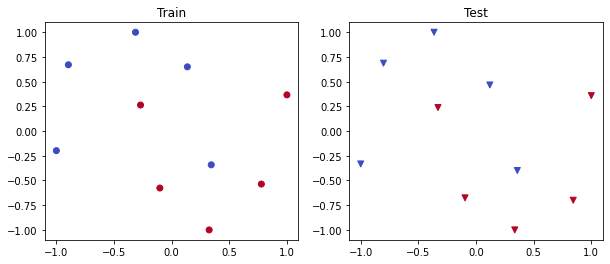

In [2]:
# Generate data set
X_train, y_train = make_moons(10, noise=0.05, random_state=0)
X_test, y_test = make_moons(10, noise=0.05, random_state=1024)

# rescaling
X_train = MinMaxScaler(feature_range=(-1, 1), copy=False).fit_transform(X_train)
X_test = MinMaxScaler(feature_range=(-1, 1), copy=False).fit_transform(X_test)

# Visualize respectively the training and testing set
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].scatter(X_train[:,0], X_train[:,1], 
              marker='o', c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)))
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[1].scatter(X_test[:,0], X_test[:,1], marker='v', c = plt.cm.coolwarm(np.array(y_test, dtype=np.float32)))
plt.show()

In [3]:
# Visualize the decision function, boundary, and margins of +- 0.2
def visualize_decision_bound(clf):
    
    # Create a 10x10 mesh in the data plan 
    x_min, x_max = X_train[:,0].min(), X_train[:,0].max()
    y_min, y_max = X_train[:,1].min(), X_train[:,1].max()
    margin = 0.2
    XX, YY = np.meshgrid(np.linspace(x_min-margin, x_max+margin, 10), 
                         np.linspace(y_min-margin, y_max+margin, 10))
    
    # Calculate the decision function value on the 10x10 mesh
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z_qke = Z.reshape(XX.shape)
    
    # visualize the decision function and boundary
    plt.figure(figsize=(8,8))
    plt.contourf(XX, YY, Z_qke ,vmin=-1., vmax=1., levels=20,
                 cmap=plt.cm.coolwarm, alpha=1)
    plt.scatter(X_train[:,0], X_train[:,1], marker='o', s=100,
                c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)),
                edgecolor='k')
    plt.scatter(X_test[:,0], X_test[:,1], marker='s', s=100,
                c = plt.cm.coolwarm(np.array(y_test, dtype=np.float32)),
                edgecolor='k')
    plt.contour(XX, YY, Z_qke, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.2, 0, .2])

In [4]:
def visualize_projected_dataset(proj_kernel, X):
    X_proj = [proj_kernel.projected_feature_map(x) for x in X]
    X_proj = np.array(X_proj)
    print(X_proj.shape)

    fig = plt.figure(figsize=plt.figaspect(0.5))
    
    # Original dataset
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(X[:,0], X[:,1], marker='o', s=100,
               c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)),
               edgecolor=None)

    # Projected dataset
    d = len(X_proj[0]) 
    if d == 2:
        ax = fig.add_subplot(1, 2, 2)
        ax.scatter(X_proj[:,0], X_proj[:,1], marker='s', s=200,
                   c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)),
                   edgecolor=None)
    elif d == 3:
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        ax.scatter(X_proj[:,0], X_proj[:,1], X_proj[:,2], marker='s', s=200,
                   c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)),
                   edgecolor=None)
    else:
        # print(d)
        assert False, f"Data dimension is too high to visualize! dim={d}"

    plt.tight_layout()
    plt.show()

# Pauli Feature Map

## RX-CZ

### Original QK

     ┌────────────┐               ┌────────────┐ 
q_0: ┤ Rx(x[0]*α) ├───────■───────┤ Ry(x[1]*α) ├─
     ├────────────┤ ┌─────┴──────┐└─────┬──────┘ 
q_1: ┤ Rx(x[1]*α) ├─┤ Ry(x[0]*α) ├──────■────────
     └────────────┘ └────────────┘               

Train scores:
   Balanced accuracy:  0.80
                  F1:  0.80
             ROC_AUC:  0.84
                 MCC:  0.60

Test scores:
   Balanced accuracy:  0.80
                  F1:  0.80
             ROC_AUC:  0.84
                 MCC:  0.60


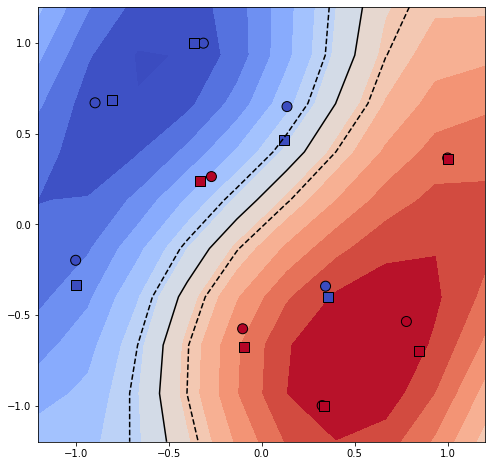

In [5]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 1

from qksvm.QuantumFeatureMap import QuantumFeatureMap
fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['RX', 'CRY'], entanglement='ring',
)
print(fm.draw(plot_barriers=False, fold=150))

svc = QKSVC(feature_map=fm, alpha=np.pi/2, C=1.0, random_state=seed)
svc.fit(X_train, y_train)

train_scores = get_scores(svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(svc)

### Projected QK

#### xyz_sum

     ┌────────────┐               ┌────────────┐ 
q_0: ┤ Rx(x[0]*α) ├───────■───────┤ Ry(x[1]*α) ├─
     ├────────────┤ ┌─────┴──────┐└─────┬──────┘ 
q_1: ┤ Rx(x[1]*α) ├─┤ Ry(x[0]*α) ├──────■────────
     └────────────┘ └────────────┘               

Train scores:
   Balanced accuracy:  0.90
                  F1:  0.90
             ROC_AUC:  1.00
                 MCC:  0.82

Test scores:
   Balanced accuracy:  0.90
                  F1:  0.90
             ROC_AUC:  1.00
                 MCC:  0.82


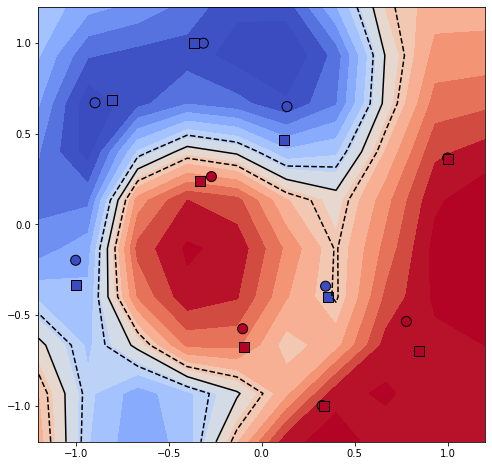

In [6]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 1

from qksvm.QuantumFeatureMap import QuantumFeatureMap
fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['RX', 'CRY'], entanglement='ring',
)
print(fm.draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({fm.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=1.0, projection='xyz_sum', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

(10, 2)


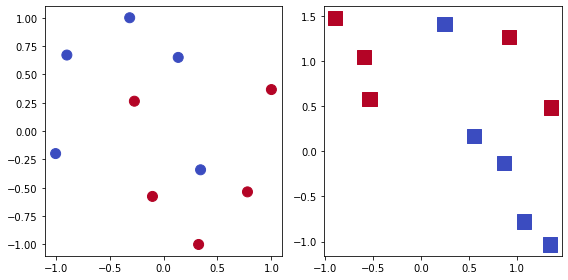

In [7]:
visualize_projected_dataset(proj_kernel, X_train)

#### xyz

     ┌────────────┐               ┌────────────┐ 
q_0: ┤ Rx(x[0]*α) ├───────■───────┤ Ry(x[1]*α) ├─
     ├────────────┤ ┌─────┴──────┐└─────┬──────┘ 
q_1: ┤ Rx(x[1]*α) ├─┤ Ry(x[0]*α) ├──────■────────
     └────────────┘ └────────────┘               

Train scores:
   Balanced accuracy:  0.90
                  F1:  0.90
             ROC_AUC:  1.00
                 MCC:  0.82

Test scores:
   Balanced accuracy:  0.90
                  F1:  0.90
             ROC_AUC:  1.00
                 MCC:  0.82


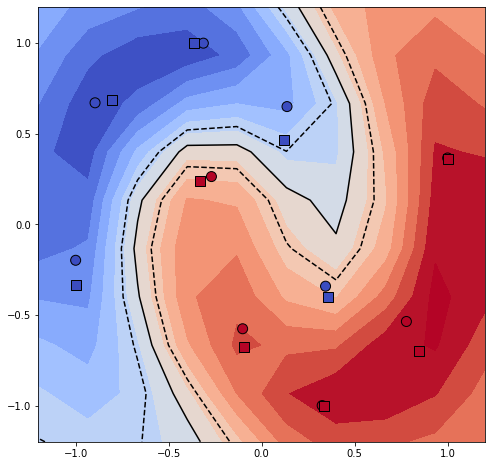

In [8]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 1

from qksvm.QuantumFeatureMap import QuantumFeatureMap
fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['RX', 'CRY'], entanglement='ring',
)
print(fm.draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({fm.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=1.0, projection='xyz', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

# ZZ Feature Map

### Original QK

     ┌───┐┌────────────┐                      ┌───┐┌────────────┐                      
q_0: ┤ H ├┤ Rz(x[0]*α) ├─■────────────────────┤ H ├┤ Rz(x[0]*α) ├─■────────────────────
     ├───┤├────────────┤ │ZZ(x[0]*x[1]*α**2)  ├───┤├────────────┤ │ZZ(x[0]*x[1]*α**2)  
q_1: ┤ H ├┤ Rz(x[1]*α) ├─■────────────────────┤ H ├┤ Rz(x[1]*α) ├─■────────────────────
     └───┘└────────────┘                      └───┘└────────────┘                      

Train scores:
   Balanced accuracy:  0.70
                  F1:  0.70
             ROC_AUC:  0.88
                 MCC:  0.41

Test scores:
   Balanced accuracy:  0.70
                  F1:  0.70
             ROC_AUC:  0.92
                 MCC:  0.41


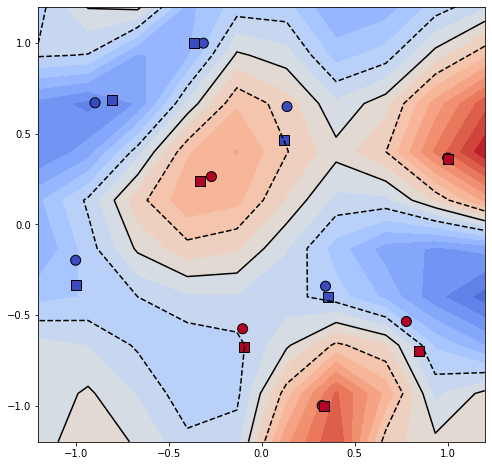

In [9]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 2

from qksvm.QuantumEmbedding import ZZ_FeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

def data_map(x, y):
    return x*y

fm = ZZ_FeatureMap(n_features, n_qubits, n_layers, data_map_func=data_map)
print(fm.draw(plot_barriers=False, fold=150))

qsvc = QKSVC(feature_map=fm, alpha=np.pi/2, C=1.0, random_state=seed)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)

### Projected QK

     ┌───┐┌────────────┐                      ┌───┐┌────────────┐                      
q_0: ┤ H ├┤ Rz(x[0]*α) ├─■────────────────────┤ H ├┤ Rz(x[0]*α) ├─■────────────────────
     ├───┤├────────────┤ │ZZ(x[0]*x[1]*α**2)  ├───┤├────────────┤ │ZZ(x[0]*x[1]*α**2)  
q_1: ┤ H ├┤ Rz(x[1]*α) ├─■────────────────────┤ H ├┤ Rz(x[1]*α) ├─■────────────────────
     └───┘└────────────┘                      └───┘└────────────┘                      

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.90
                  F1:  0.90
             ROC_AUC:  1.00
                 MCC:  0.82


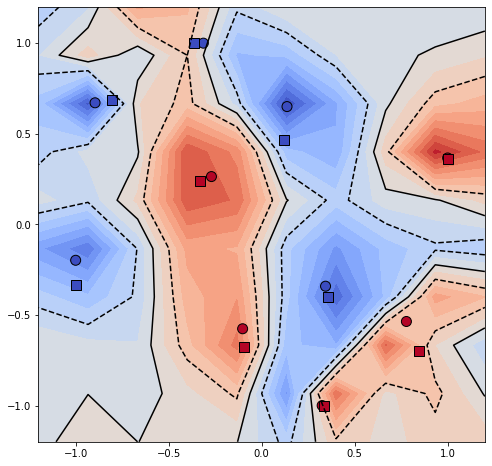

In [10]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 2

from qksvm.QuantumEmbedding import ZZ_FeatureMap

def data_map(x, y):
    return x*y

fm = ZZ_FeatureMap(n_features, n_qubits, n_layers, data_map_func=data_map)
print(fm.draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({fm.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=2.0, projection='xyz', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

# Hamiltonian Evolution Feature Map

## Original QK

      ┌─────────────────────┐ ┌──────────────────────┐ ┌──────────────────────┐┌──────────────────┐┌──────────────────┐                 »
q_0: ─┤ x^-0.50183952461055 ├─┤ y^1.8028572256396647 ├─┤ z^0.9279757672456204 ├┤0                 ├┤0                 ├─■───────────────»
      ├─────────────────────┴┐├──────────────────────┤┌┴──────────────────────┤│  Rxx(1.0*x[0]*α) ││  Ryy(1.0*x[0]*α) │ │ZZ(1.0*x[0]*α) »
q_1: ─┤ x^0.3946339367881464 ├┤ y^-1.375925438230254 ├┤ z^-1.3760219186551894 ├┤1                 ├┤1                 ├─■───────────────»
     ┌┴──────────────────────┤├──────────────────────┤└┬──────────────────────┤└──────────────────┘└──────────────────┘                 »
q_2: ┤ x^-1.7676655513272022 ├┤ y^1.4647045830997407 ├─┤ z^0.4044600469728352 ├─────────────────────────────────────────────────────────»
     └───────────────────────┘└──────────────────────┘ └──────────────────────┘                                                         »
«                                 

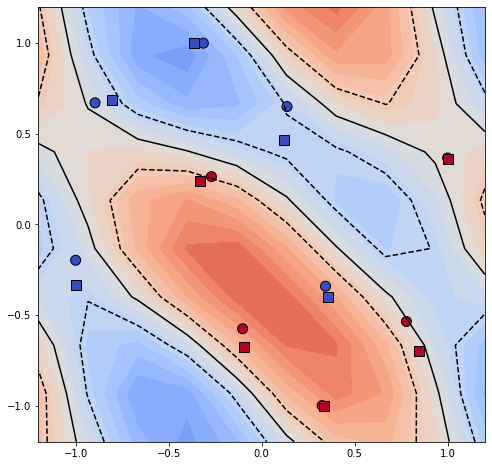

In [11]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 1

from qksvm.QuantumEmbedding import SingleQubitWall
qc1 = SingleQubitWall(n_qubits, random_state=42)

from qksvm.QuantumEmbedding import HamiltonianEvolution 
qc2 = HamiltonianEvolution(n_features, n_qubits, n_trotter)

from qiskit import QuantumRegister, QuantumCircuit
fm = QuantumCircuit(n_qubits)
fm.append(qc1.to_instruction(), fm.qubits)
fm.append(qc2.to_instruction(), fm.qubits)
print(fm.decompose().draw(plot_barriers=False, fold=150))

fm.alpha = qc2.alpha
svc = QKSVC(feature_map=fm, alpha=np.pi/2, C=1.0, random_state=seed)
svc.fit(X_train, y_train)

train_scores = get_scores(svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(svc)

## Projected QK

      ┌─────────────────────┐ ┌──────────────────────┐ ┌──────────────────────┐┌──────────────────┐┌──────────────────┐                 »
q_0: ─┤ x^-0.50183952461055 ├─┤ y^1.8028572256396647 ├─┤ z^0.9279757672456204 ├┤0                 ├┤0                 ├─■───────────────»
      ├─────────────────────┴┐├──────────────────────┤┌┴──────────────────────┤│  Rxx(1.0*x[0]*α) ││  Ryy(1.0*x[0]*α) │ │ZZ(1.0*x[0]*α) »
q_1: ─┤ x^0.3946339367881464 ├┤ y^-1.375925438230254 ├┤ z^-1.3760219186551894 ├┤1                 ├┤1                 ├─■───────────────»
     ┌┴──────────────────────┤├──────────────────────┤└┬──────────────────────┤└──────────────────┘└──────────────────┘                 »
q_2: ┤ x^-1.7676655513272022 ├┤ y^1.4647045830997407 ├─┤ z^0.4044600469728352 ├─────────────────────────────────────────────────────────»
     └───────────────────────┘└──────────────────────┘ └──────────────────────┘                                                         »
«                                 

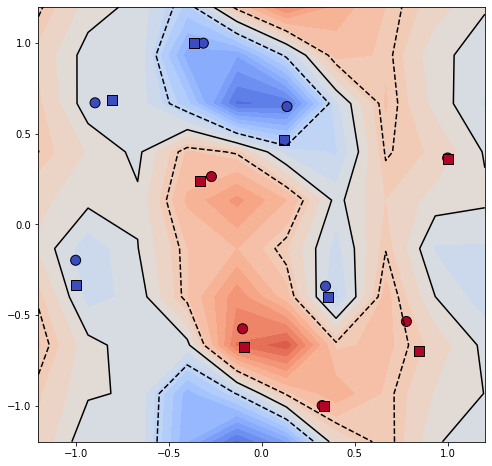

In [12]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 1

from qksvm.QuantumEmbedding import SingleQubitWall
qc1 = SingleQubitWall(n_qubits, random_state=42)

from qksvm.QuantumEmbedding import HamiltonianEvolution
qc2 = HamiltonianEvolution(n_features, n_qubits, n_trotter)

from qiskit import QuantumRegister, QuantumCircuit
fm = QuantumCircuit(n_qubits)
fm.append(qc1.to_instruction(), fm.qubits)
fm.append(qc2.to_instruction(), fm.qubits)
print(fm.decompose().draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({qc2.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=1.0, projection='xyz', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

## Modifications

### Original QK

     ┌────────────┐ ┌──────────────────┐┌──────────────────┐                                                                           
q_0: ┤ Rx(x[0]*α) ├─┤0                 ├┤0                 ├─■─────────────────────────────────────────────────────────────────────────
     ├────────────┤ │  Rxx(1.0*x[0]*α) ││  Ryy(1.0*x[0]*α) │ │ZZ(1.0*x[0]*α) ┌──────────────────┐┌──────────────────┐                  
q_1: ┤ Rx(x[1]*α) ├─┤1                 ├┤1                 ├─■───────────────┤0                 ├┤0                 ├─■────────────────
     ├────────────┤ └──────────────────┘└──────────────────┘                 │  Rxx(1.0*x[1]*α) ││  Ryy(1.0*x[1]*α) │ │ZZ(1.0*x[1]*α)  
q_2: ┤ Rx(x[0]*α) ├──────────────────────────────────────────────────────────┤1                 ├┤1                 ├─■────────────────
     └────────────┘                                                          └──────────────────┘└──────────────────┘                  

Train scores:
   Balanced accuracy:  1.00
     

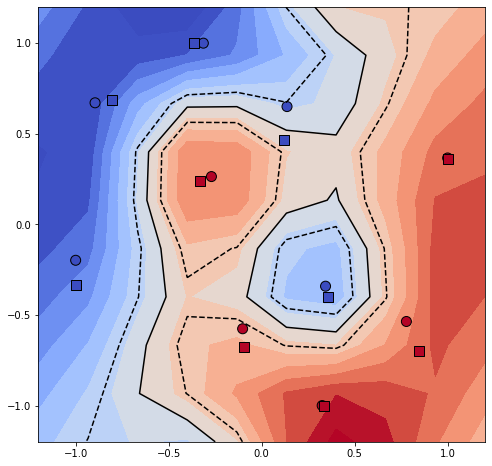

In [13]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 1

from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
alpha = Parameter('α')
qc1 = QuantumCircuit(n_qubits)
qc1.alpha = alpha
for i in range(n_qubits):
    # qc1.u(np.pi/2, alpha*x[i%n_features], alpha*x[i%n_features], i)
    qc1.rx(alpha*x[i%n_features], i)
    # qc1.ry(alpha*x[i%n_features], i)
# entangle(qc1, 'cz', connectivity='linear_')
qc1.barrier()

from qksvm.QuantumEmbedding import HamiltonianEvolution
qc2 = HamiltonianEvolution(n_features, n_qubits, n_trotter)

from qiskit import QuantumCircuit
fm = QuantumCircuit(n_qubits)
fm.append(qc1.to_instruction(), fm.qubits)
x_dict = dict(zip(qc2.parameters, qc1.parameters))
fm.append(qc2.to_instruction(x_dict), fm.qubits)
print(fm.decompose().draw(plot_barriers=False, fold=150))

fm.alpha = qc1.alpha
svc = QKSVC(feature_map=fm, alpha=np.pi/2, C=1.0, random_state=seed)
svc.fit(X_train, y_train)

train_scores = get_scores(svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(svc)

### Projected QK

     ┌────────────┐ ┌──────────────────┐┌──────────────────┐                                                                           
q_0: ┤ Rx(x[0]*α) ├─┤0                 ├┤0                 ├─■─────────────────────────────────────────────────────────────────────────
     ├────────────┤ │  Rxx(1.0*x[0]*α) ││  Ryy(1.0*x[0]*α) │ │ZZ(1.0*x[0]*α) ┌──────────────────┐┌──────────────────┐                  
q_1: ┤ Rx(x[1]*α) ├─┤1                 ├┤1                 ├─■───────────────┤0                 ├┤0                 ├─■────────────────
     ├────────────┤ └──────────────────┘└──────────────────┘                 │  Rxx(1.0*x[1]*α) ││  Ryy(1.0*x[1]*α) │ │ZZ(1.0*x[1]*α)  
q_2: ┤ Rx(x[0]*α) ├──────────────────────────────────────────────────────────┤1                 ├┤1                 ├─■────────────────
     └────────────┘                                                          └──────────────────┘└──────────────────┘                  

Train scores:
   Balanced accuracy:  1.00
     

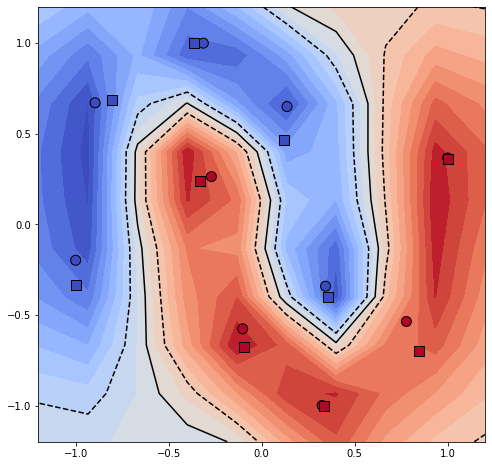

In [14]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 1

from qiskit.circuit import Parameter, ParameterVector
from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
alpha = Parameter('α')
qc1 = QuantumCircuit(n_qubits)
qc1.alpha = alpha
for i in range(n_qubits):
    # qc1.u(np.pi/2, alpha*x[i%n_features], alpha*x[i%n_features], i)
    qc1.rx(alpha*x[i%n_features], i)
    # qc1.ry(alpha*x[i%n_features], i)
# entangle(qc1, 'cz', connectivity='linear_')
qc1.barrier()

from qksvm.QuantumEmbedding import HamiltonianEvolution
qc2 = HamiltonianEvolution(n_features, n_qubits, n_trotter)

from qiskit import QuantumCircuit
fm = QuantumCircuit(n_qubits)
fm.append(qc1.to_instruction(), fm.qubits)
x_dict = dict(zip(qc2.parameters, qc1.parameters))
fm.append(qc2.to_instruction(x_dict), fm.qubits)
print(fm.decompose().draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({qc1.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=1.0, projection='xyz', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

     ┌────────────┐ ┌──────────────────┐┌──────────────────┐                                                                           »
q_0: ┤ Rx(x[0]*α) ├─┤0                 ├┤0                 ├─■─────────────────────────────────────────────────────────────────────────»
     ├────────────┤ │  Rxx(0.5*x[0]*α) ││  Ryy(0.5*x[0]*α) │ │ZZ(0.5*x[0]*α) ┌──────────────────┐┌──────────────────┐                  »
q_1: ┤ Rx(x[1]*α) ├─┤1                 ├┤1                 ├─■───────────────┤0                 ├┤0                 ├─■────────────────»
     ├────────────┤ └──────────────────┘└──────────────────┘                 │  Rxx(0.5*x[1]*α) ││  Ryy(0.5*x[1]*α) │ │ZZ(0.5*x[1]*α)  »
q_2: ┤ Rx(x[0]*α) ├──────────────────────────────────────────────────────────┤1                 ├┤1                 ├─■────────────────»
     └────────────┘                                                          └──────────────────┘└──────────────────┘                  »
«     ┌──────────────────┐┌──────────────

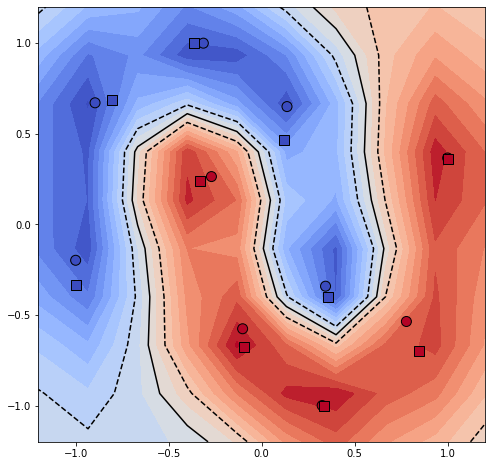

In [15]:
n_features = len(X_train[0])
n_qubits = 3
n_trotter = 2
n_layers = 1

from qiskit.circuit import Parameter, ParameterVector
from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
alpha = Parameter('α')

fm = QuantumCircuit(n_qubits)
fm.alpha = alpha

j = 0
for l in range(n_layers):
    
    for i in range(n_qubits):
        fm.rx(alpha*x[j%n_features], i); j += 1
    # entangle(fm, 'cz', connectivity='linear_')
    fm.barrier()

    # Add Hamiltonian evolution circuit
    p = (n_qubits/3)/n_trotter
    k = 0
    for t in range(n_trotter):
        for j in range(max(n_features, n_qubits-1)):
            fm.rxx(alpha*p*x[k%n_features], j%n_qubits, (j+1)%n_qubits)
            fm.ryy(alpha*p*x[k%n_features], j%n_qubits, (j+1)%n_qubits)
            fm.rzz(alpha*p*x[k%n_features], j%n_qubits, (j+1)%n_qubits)
            k += 1
        fm.barrier()

print(fm.draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({fm.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=1.0, projection='xyz', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

     ┌──────────────────────┐ ┌──────────────────┐┌──────────────────┐                                                                           
q_0: ┤ U(π/2,x[0]*α,x[1]*α) ├─┤0                 ├┤0                 ├─■─────────────────────────────────────────────────────────────────────────
     ├──────────────────────┤ │  Rxx(1.0*x[0]*α) ││  Ryy(1.0*x[0]*α) │ │ZZ(1.0*x[0]*α) ┌──────────────────┐┌──────────────────┐                  
q_1: ┤ U(π/2,x[1]*α,x[0]*α) ├─┤1                 ├┤1                 ├─■───────────────┤0                 ├┤0                 ├─■────────────────
     ├──────────────────────┤ └──────────────────┘└──────────────────┘                 │  Rxx(1.0*x[1]*α) ││  Ryy(1.0*x[1]*α) │ │ZZ(1.0*x[1]*α)  
q_2: ┤ U(π/2,x[0]*α,x[1]*α) ├──────────────────────────────────────────────────────────┤1                 ├┤1                 ├─■────────────────
     └──────────────────────┘                                                          └──────────────────┘└────────────────

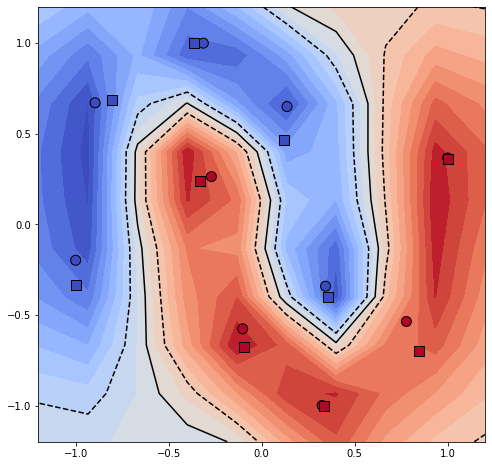

In [16]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 1

from qiskit.circuit import Parameter, ParameterVector
from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
alpha = Parameter('α')
qc1 = QuantumCircuit(n_qubits)
qc1.alpha = alpha
for i in range(n_qubits):
    qc1.u(np.pi/2, alpha*x[i%n_features], alpha*x[(i+1)%n_features], i)
    # qc1.rx(alpha*x[i%n_features], i)
    # qc1.ry(alpha*x[i%n_features], i)
# entangle(qc1, 'cz', connectivity='linear_')
qc1.barrier()

from qksvm.QuantumEmbedding import HamiltonianEvolution
qc2 = HamiltonianEvolution(n_features, n_qubits, n_trotter)

from qiskit import QuantumCircuit
fm = QuantumCircuit(n_qubits)
fm.append(qc1.to_instruction(), fm.qubits)
x_dict = dict(zip(qc2.parameters, qc1.parameters))
fm.append(qc2.to_instruction(x_dict), fm.qubits)
print(fm.decompose().draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({qc1.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=1.0, projection='xyz', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

# Kernel Target Alignement

In [17]:
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.utils import algorithm_globals
from qksvm.QuantumKernelTraining import QKTKernel

algorithm_globals.random_seed = seed
backend = QuantumInstance(
    AerSimulator(
        method='statevector',
        max_parallel_threads=8,
    ),
    seed_simulator=seed, seed_transpiler=seed,
)

## ZZ embedding

In [18]:
n_features = len(X_train[0])
n_qubits = 2 
n_layers = 2

from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=1+n_layers*n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
fm.scale = True

k = 1
for l in range(n_layers):
    # training
    for i in range(n_qubits):
        fm.ry(theta[k], i); k += 1
    # entangle(fm, 'cz', connectivity='linear')
    # embedding
    j = 0
    for i in range(n_qubits):
        fm.h(i)
        fm.rz(theta[0]*x[j%n_features], i); j += 1
    for i in range(n_qubits-1):
        v = theta[0]*x[j%n_features]*x[(j+1)%n_features]; j += 1
        fm.rzz(v, i, (i+1)%n_qubits)
    fm.barrier()
print(fm.draw(plot_barriers=False, fold=150))

     ┌──────────┐┌───┐┌───────────────┐                      ┌──────────┐┌───┐┌───────────────┐                      
q_0: ┤ Ry(θ[1]) ├┤ H ├┤ Rz(x[0]*θ[0]) ├─■────────────────────┤ Ry(θ[3]) ├┤ H ├┤ Rz(x[0]*θ[0]) ├─■────────────────────
     ├──────────┤├───┤├───────────────┤ │ZZ(x[0]*x[1]*θ[0])  ├──────────┤├───┤├───────────────┤ │ZZ(x[0]*x[1]*θ[0])  
q_1: ┤ Ry(θ[2]) ├┤ H ├┤ Rz(x[1]*θ[0]) ├─■────────────────────┤ Ry(θ[4]) ├┤ H ├┤ Rz(x[1]*θ[0]) ├─■────────────────────
     └──────────┘└───┘└───────────────┘                      └──────────┘└───┘└───────────────┘                      


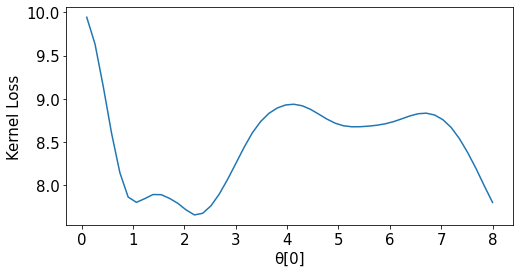

In [19]:
from qksvm.LossFunctions import SVCLoss

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

loss.plot(fm, X_train, y_train, init_params, backend)

SVCLoss optimal value:  4.25175917583492
Optimal parameters: [2.36933936 3.18358838 2.26992699 1.84831995 3.13038144]

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


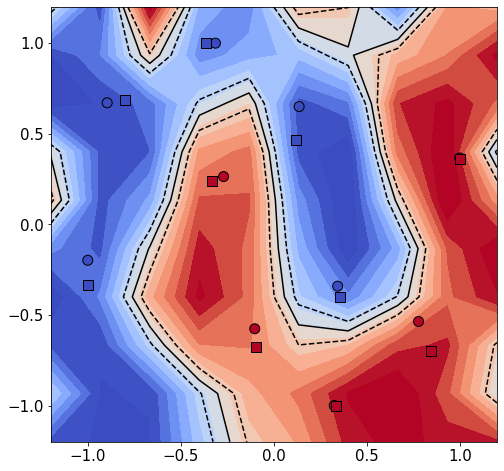

In [20]:
C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=100,
    C=C, class_weight=class_weight,
    seed=seed, plot=False,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)

## Hamiltonian evolution

In [21]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 4

from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=1+n_trotter*n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
fm.scale = True
p = (n_qubits/3)/n_trotter

# k = 1
# for i in range(n_qubits):
#     fm.rx(theta[k], i)
#     fm.ry(theta[k], i)
#     fm.rz(theta[k], i)
#     k += 1

j = 0
k = 1
for t in range(n_trotter):
    for i in range(n_qubits):
        # fm.rx(theta[k], i); k += 1
        fm.ry(theta[k], i); k += 1
        # fm.rz(theta[k], i); k += 1
    for i in range(n_qubits-1):
        v = theta[0]*p*x[j%n_features]; j += 1
        fm.rxx(v, i, (i+1)%n_qubits)
        fm.ryy(v, i, (i+1)%n_qubits)
        fm.rzz(v, i, (i+1)%n_qubits)
    fm.barrier()
    
print(fm.draw(plot_barriers=False, fold=150))

     ┌──────────┐┌──────────────────────┐┌──────────────────────┐                                                                     »
q_0: ┤ Ry(θ[1]) ├┤0                     ├┤0                     ├─■───────────────────────────────────────────────────────────────────»
     ├──────────┤│  Rxx(0.25*x[0]*θ[0]) ││  Ryy(0.25*x[0]*θ[0]) │ │ZZ(0.25*x[0]*θ[0]) ┌──────────────────────┐┌──────────────────────┐»
q_1: ┤ Ry(θ[2]) ├┤1                     ├┤1                     ├─■───────────────────┤0                     ├┤0                     ├»
     ├──────────┤└──────────────────────┘└──────────────────────┘                     │  Rxx(0.25*x[1]*θ[0]) ││  Ryy(0.25*x[1]*θ[0]) │»
q_2: ┤ Ry(θ[3]) ├─────────────────────────────────────────────────────────────────────┤1                     ├┤1                     ├»
     └──────────┘                                                                     └──────────────────────┘└──────────────────────┘»
«                           ┌──────────┐┌───────

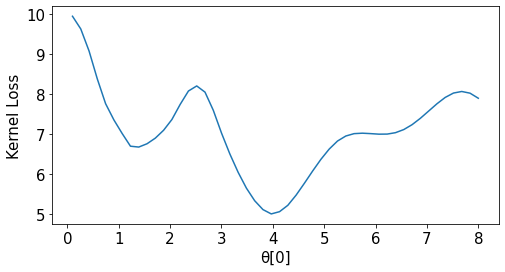

In [22]:
from qksvm.LossFunctions import SVCLoss

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

loss.plot(fm, X_train, y_train, init_params, backend)

SVCLoss optimal value:  3.7275279651088438
Optimal parameters: [2.64431381 3.31427488 1.29057048 1.55899948 3.7100639  3.98848419
 5.732912   4.71981152 4.04156114 3.67437325 3.08562151 3.9532474
 1.22503063]

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


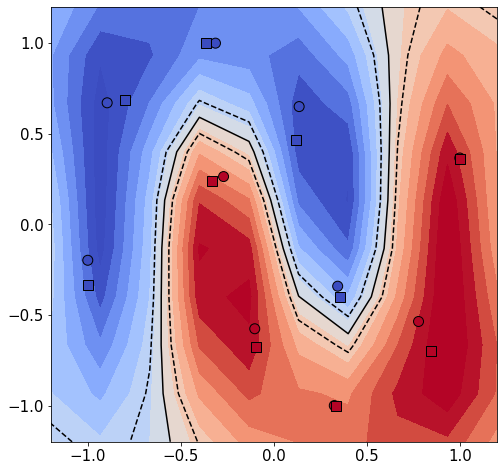

In [23]:
C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=100,
    C=C, class_weight=class_weight,
    seed=seed, plot=False,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)

## Covariant quantum kernel map

In [24]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 2

from qksvm.QuantumFeatureMap import QuantumFeatureMap
fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['rx', 'rz', 'cz', 'RY'], entanglement='linear',
    scale=True,
)
print(fm.draw(plot_barriers=False, fold=150))


     ┌──────────┐ ┌──────────┐     ┌───────────────┐ ┌──────────┐ ┌──────────┐     ┌───────────────┐ 
q_0: ┤ Rx(θ[1]) ├─┤ Rz(θ[3]) ├──■──┤ Ry(x[0]*θ[0]) ├─┤ Rx(θ[5]) ├─┤ Rz(θ[7]) ├──■──┤ Ry(x[0]*θ[0]) ├─
     ├──────────┤ ├──────────┤  │  ├───────────────┤ ├──────────┤ ├──────────┤  │  ├───────────────┤ 
q_1: ┤ Rx(θ[2]) ├─┤ Rz(θ[4]) ├──■──┤ Ry(x[1]*θ[0]) ├─┤ Rx(θ[6]) ├─┤ Rz(θ[8]) ├──■──┤ Ry(x[1]*θ[0]) ├─
     └──────────┘ └──────────┘     └───────────────┘ └──────────┘ └──────────┘     └───────────────┘ 


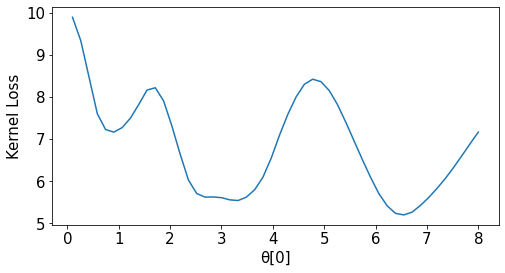

In [25]:
from qksvm.LossFunctions import SVCLoss

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

loss.plot(fm, X_train, y_train, init_params, backend)

SVCLoss optimal value:  4.126359108088283
Optimal parameters: [2.38645188 2.39501796 2.11789358 0.84380153 3.03399413 3.75426194
 7.49282159 5.7279293  5.10237726]

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


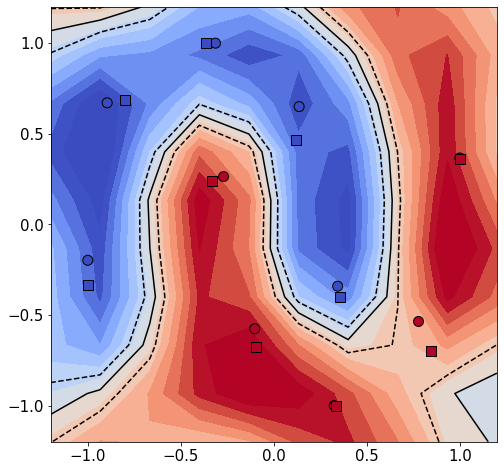

In [26]:
C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=100,
    C=C, class_weight=class_weight,
    seed=seed, plot=False,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)

## U maps

In [27]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 4

from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=1+n_layers*n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
fm.scale = True

k = 1
for l in range(n_layers):
    for i in range(n_qubits):
        fm.u(np.pi/2, theta[0]*x[i%n_features], theta[k], i)
        k += 1
    entangle(fm, 'cz', connectivity='linear_')
fm.barrier()

print(fm.draw(plot_barriers=False, fold=150))

     ┌───────────────────────┐    ┌───────────────────────┐    ┌───────────────────────┐    ┌───────────────────────┐     
q_0: ┤ U(π/2,x[0]*θ[0],θ[1]) ├─■──┤ U(π/2,x[0]*θ[0],θ[3]) ├─■──┤ U(π/2,x[0]*θ[0],θ[5]) ├─■──┤ U(π/2,x[0]*θ[0],θ[7]) ├─■───
     ├───────────────────────┤ │  ├───────────────────────┤ │  ├───────────────────────┤ │  ├───────────────────────┤ │   
q_1: ┤ U(π/2,x[1]*θ[0],θ[2]) ├─■──┤ U(π/2,x[1]*θ[0],θ[4]) ├─■──┤ U(π/2,x[1]*θ[0],θ[6]) ├─■──┤ U(π/2,x[1]*θ[0],θ[8]) ├─■───
     └───────────────────────┘    └───────────────────────┘    └───────────────────────┘    └───────────────────────┘     


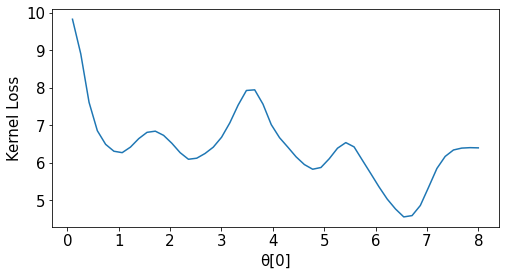

In [28]:
from qksvm.LossFunctions import SVCLoss

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

loss.plot(fm, X_train, y_train, init_params, backend)

SVCLoss optimal value:  3.5065004673212097
Optimal parameters: [2.18822661 1.17328519 1.0867747  2.65668165 3.328013   4.64406283
 5.768029   5.11583884 5.77060973]

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


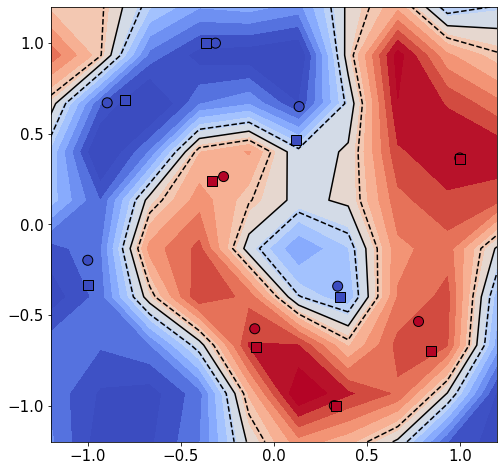

In [29]:
C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=1000,
    C=C, class_weight=class_weight,
    seed=seed, plot=False,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)